In [1]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Dropout
from tensorflow.keras.optimizers import Nadam
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
from sklearn.metrics import r2_score
from prettytable import PrettyTable

In [2]:
import random
import numpy
from tensorflow.compat.v1.random import set_random_seed

random.seed(1)
numpy.random.seed(1)
set_random_seed(2)

In [3]:
df = pd.read_csv('merged_data.csv',parse_dates=True,skipinitialspace=True,index_col='Date')
df.head()

open     high      low  high_open  open_low  total_pips  \
Date                                                                     
2018-01-02  1.20276  1.20795  1.20232    0.00519   0.00044     0.00563   
2018-01-03  1.20572  1.20654  1.20019    0.00082   0.00553     0.00635   
2018-01-04  1.20133  1.20879  1.20037    0.00746   0.00096     0.00842   
2018-01-05  1.20659  1.20819  1.20198    0.00160   0.00461     0.00621   
2018-01-08  1.20266  1.20510  1.19556    0.00244   0.00710     0.00954   

            return_1  return_5        RSI   UpperBB  ...  \
Date                                                 ...   
2018-01-02  0.004733  0.016618  98.190709  1.200916  ...   
2018-01-03 -0.003691  0.013182  81.858948  1.203329  ...   
2018-01-04  0.004478  0.015262  83.542899  1.206893  ...   
2018-01-05 -0.003190  0.007243  67.128713  1.209079  ...   
2018-01-08 -0.005204 -0.002916  43.169399  1.209862  ...   

            Subjectivity_article  Polarity_article  Compound_title  \
Date                                                                 
2018-01-02              0.439044          0.137370         -0.9098   
2018-01-03              0.328112          0.068333          0.4404   
2018-01-04              0.417297          0.072682         -0.7845   
2018-01-05              0.376388          0.102737          0.5994   
2018-01-08              0.435464          0.156300          0.7506   

            Negative_title  Neutral_title  Positive_title  Compound_article  \
Date                                                                          
2018-01-02           0.315          0.639           0.046            0.9337   
2018-01-03           0.114          0.741           0.145            0.9971   
2018-01-04           0.165          0.835           0.000            0.9842   
2018-01-05           0.077          0.775           0.148           -0.4404   
2018-01-08           0.041          0.795           0.165            0.9941   

            Negative_article  Neutral_article  Positive_article  
Date                                                             
2018-01-02             0.094            0.802             0.105  
2018-01-03             0.059            0.827             0.114  
2018-01-04             0.075            0.816             0.109  
2018-01-05             0.063            0.881             0.056  
2018-01-08             0.063            0.825             0.111  

[5 rows x 30 columns]

In [4]:
df.isna().sum()

open                    0
high                    0
low                     0
high_open               0
open_low                0
total_pips              0
return_1                0
return_5                0
RSI                     0
UpperBB                 0
LowerBB                 0
MACD                    0
Signal                  0
EVM                     0
ROC                     0
ForceIndex              0
close                   0
close_shifted           0
Subjectivity_title      0
Polarity_title          0
Subjectivity_article    0
Polarity_article        0
Compound_title          0
Negative_title          0
Neutral_title           0
Positive_title          0
Compound_article        0
Negative_article        0
Neutral_article         0
Positive_article        0
dtype: int64

In [5]:
df[df.columns[1:]].corr()['close_shifted']

high                    0.986350
low                     0.985924
high_open               0.123790
open_low               -0.001951
total_pips              0.124645
return_1                0.086199
return_5                0.173779
RSI                     0.161053
UpperBB                 0.925838
LowerBB                 0.924757
MACD                    0.513156
Signal                  0.561782
EVM                     0.159190
ROC                     0.173779
ForceIndex              0.154647
close                   0.989912
close_shifted           1.000000
Subjectivity_title      0.228731
Polarity_title          0.062156
Subjectivity_article    0.265960
Polarity_article        0.163272
Compound_title         -0.013450
Negative_title          0.117289
Neutral_title          -0.154220
Positive_title          0.078933
Compound_article        0.101973
Negative_article       -0.081129
Neutral_article         0.011888
Positive_article        0.076589
Name: close_shifted, dtype: float64

In [6]:
raw_columns =['open', 'high', 'low','close',"close_shifted"]

forex_additional_column = ['open', 'high', 'low', 'high_open', 'open_low', 'total_pips',
       'return_1', 'return_5', 'RSI', 'UpperBB', 'LowerBB', 'MACD', 'Signal',
       'EVM', 'ROC', 'ForceIndex', 'close',"close_shifted"]

all_columns = [ 'open', 'high', 'low', 'high_open', 'open_low', 'total_pips',
       'return_1', 'return_5', 'RSI', 'UpperBB', 'LowerBB', 'MACD', 'Signal',
       'EVM', 'ROC', 'ForceIndex', 'close','Subjectivity_title', 'Polarity_title',
       'Subjectivity_article', 'Polarity_article', 'Compound_title',
       'Negative_title', 'Neutral_title', 'Positive_title', 'Compound_article',
       'Negative_article', 'Neutral_article', 'Positive_article',"close_shifted"]
       

news_columns_title = [ 'open', 'high', 'low', 'close','Subjectivity_title', 'Polarity_title',
        'Compound_title',
       'Negative_title', 'Neutral_title', 'Positive_title',"close_shifted"]

news_columns = [ 'open', 'high', 'low', 'close','Subjectivity_title', 'Polarity_title',
       'Subjectivity_article', 'Polarity_article', 'Compound_title',
       'Negative_title', 'Neutral_title', 'Positive_title', 'Compound_article',
       'Negative_article', 'Neutral_article', 'Positive_article',"close_shifted"]

correlated_20 = [ 'open', 'high', 'low','UpperBB', 'LowerBB', 'MACD', 'Signal',
        'close','Subjectivity_title','Subjectivity_article', "close_shifted"]

correlated_10 = [ 'open', 'high', 'low', 'high_open', 'total_pips',
        'return_5', 'RSI', 'UpperBB', 'LowerBB', 'MACD', 'Signal',
       'EVM', 'ROC', 'ForceIndex', 'close','Subjectivity_title', 
       'Subjectivity_article', 'Polarity_article', 
       'Negative_title', 'Compound_article',
       "close_shifted"]
       
       

In [11]:
def make_dataset(df):
    X = df.drop('close_shifted',axis=1).values
    y = df['close_shifted'].values

    # scaling the feature dataset
    scaler_X = MinMaxScaler (feature_range=(-1, 1))
    X = np.array(X).reshape((len(X) ,X.shape[1]))
    X = scaler_X.fit_transform(X)

    # scaling the target variable
    scaler_y = MinMaxScaler (feature_range=(-1, 1))
    y = np.array (y).reshape ((len( y), 1))
    y = scaler_y.fit_transform (y)


    data_to_use = (len(df)-1)

    # using 80% of data for training
    train_end = int(data_to_use*0.8)
    total_data = len(df)
    start = total_data - data_to_use

    # printing number of records in the training and test datasets
    print("Number of records in Training Data:", train_end)
    print("Number of records in Test Data:", total_data - train_end)

    # preparing training and test dataset
    xtrain = X[0 : train_end,]
    xtest = X[train_end+1 : len(X),]    
    ytrain = y[0 : train_end] 
    ytest = y[train_end+1 : len(y)]  



    # Code for n_days data creation
    
    # X_train = xtrain
    # y_train = ytrain
    # X_test = xtest
    # y_test = ytest
    # n_steps = 2
    # X_train_final = []
    # y_train_final = []
    # X_test_final = []
    # y_test_final = []
    # for i in range(n_steps, X_train.shape[0]):
    #     X_train_final.append(X_train[i-n_steps:i])
    #     y_train_final.append(y_train[i])
    # xtrain, ytrain = np.array(X_train_final), np.array(y_train_final)



    # for i in range(n_steps, X_test.shape[0]):
    #     X_test_final.append(X_test[i-n_steps:i])
    #     y_test_final.append(y_test[i])
    # xtest, ytest = np.array(X_test_final), np.array(y_test_final)


    
    
    xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
    xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))


    # printing the shape of the training and the test datasets
    print('Number of rows and columns in the Training set X:', xtrain.shape, 'and y:', ytrain.shape)
    print('Number of rows and columns in the Test set X:', xtest.shape, 'and y:', ytest.shape)

    return xtrain,ytrain,xtest,ytest


In [12]:
activations=['tanh', 'sigmoid', 'relu']
def mse(predictions, targets):
        return ((predictions - targets) ** 2).mean()

In [13]:
class Models_FLF():
    def __init__(self, activations):
        self.activations = activations
        self.history_dictionary = {}
        self.opt = Nadam(lr=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=None, schedule_decay=0.0004)
        self.predictions = {}

    



    
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    
    def train_all(self, xtrain, ytrain, units=100, epochs = 20, verbose=2):
        
        for i, act in enumerate(self.activations):
            start =  time.time()
            cand = Sequential()
            
            ## CuDNNLSTM() from tf.keras.layers.
            cand.add(LSTM(units, input_shape=(xtrain.shape[1], xtrain.shape[2]) ,  activation=act))  
            # cand.add(Dropout(0.2))
            # cand.add(LSTM(units = 200, activation = act))
            # cand.add(Dropout(0.2))
            cand.add(Dense(1))
            ############################
            cand.compile(loss='mean_squared_error', optimizer='adam')#'Nadam'
            cand_history = cand.fit(xtrain, ytrain, epochs=epochs, batch_size=72, validation_data=(xtest, ytest), verbose=verbose, shuffle=False)
            self.history_dictionary[str(act)] = (cand_history, cand)
            print("done training model with activation", act, "  ", i+1,"/", len(self.activations), "completed.")
            end =  time.time()
            print("time of execution = ", end-start, "seconds")
    
    def plot_validation_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history = pair[0]
            plt.plot(cand_history.history['val_loss'], label=str(label))
            plt.title('Candle validation loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
    
    def plot_train_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history =pair[0]
            plt.plot(cand_history.history['loss'], label= str(label))
            plt.title('Candle training loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, xtest, name="Open"):
        print('predicting candles and evaluating models...')
        # mapp = {"Open": 0, "High":1, "Low":2, "Close":3}
        # groups = {"Open": [], "High":[], "Low": [], "Close": []}
        losses = {}
        r2_scores = {}
        for label, pair in self.history_dictionary.items():
            losses[label]=[]
            r2_scores[label]=[]
            model =pair[1]
            prediCand = model.predict(xtest)
            self.predictions[label] = prediCand
            pred = prediCand[:]
            act = ytest[:]
            mean_sq_err = self.mse(act, pred)
            r2= r2_score(act, pred)
            print(" MSE for,",str(label)," => ", mean_sq_err)
            print(" R2 for,",str(label)," => ", r2)
            print(".................................................")
        
            losses[label].append(mean_sq_err)
            r2_scores[label].append(r2)
            
        return losses,r2_scores
    
    def plot(self):
        # mapp = {"Open": 0, "open":0,  "High":1, "high":1 ,   "Low":2, "low":2 , "Close":3, "close":3 }
        plt.figure(figsize=(8,5))
        # id_ = mapp[name]
        act = ytest[:]
        label_2 = 'actual price'
        plt.plot(act[:len(act)-1],label = label_2)
        for label, prediCand in self.predictions.items():
            pred = prediCand[:]
            label_1 = label+ 'Predicted price'
            plt.plot(pred[:len(pred)-1],   label = label_1)
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title('EUR/USD price')
            plt.grid(True)
            plt.legend(loc = 'best')
        plt.show()
        
    def plot_error(self, dictionary):
        plt.figure(figsize=(5, 4))
        # Make the plot
        keys = dictionary.keys()
        values = [value[0] for value in dictionary.values()]
        plt.bar(keys, values)
        plt.title("Error Comparison")
        plt.xlabel("Activations")
        plt.ylabel("MSE Error")
        plt.legend(loc= "best")
        plt.show()

    def plot_r2(self, dictionary):
        plt.figure(figsize=(5, 4))
        # Make the plot
        keys = dictionary.keys()
        values = [value[0] for value in dictionary.values()]
        plt.bar(keys, values)
        plt.legend(loc= "best")
        plt.title("R2 Scores Comparison")
        plt.xlabel("Activations")
        plt.ylabel("R2 Scores")
        plt.show()
    

# Tokenized and Stemmed

Testing df with Raw Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 4) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 4) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.326730251312256 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.6270272731781006 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.585651397705078 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005470750254963724
 R2 for, tanh  =>  0.2949181252749178
.................................................
 MSE for, sigmoid  =>  0.005626428843312729
 R2 for, sigmoid  =>  0.27485393922875745
.................................................
 MSE for, relu  =>  0.0066307

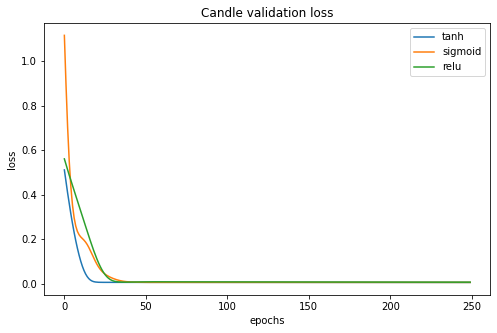


Plotting Training Loss over Epochs


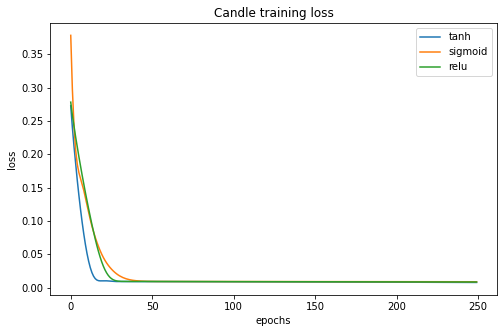

No handles with labels found to put in legend.

Plotting Best Testing Errors


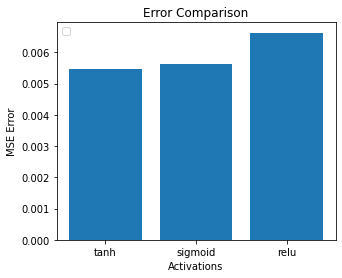

No handles with labels found to put in legend.

Plotting Best Testing r2


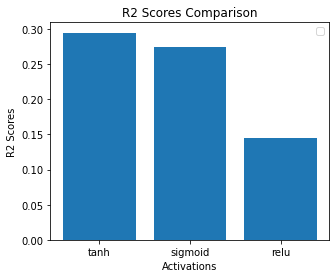


Plotting Predictions


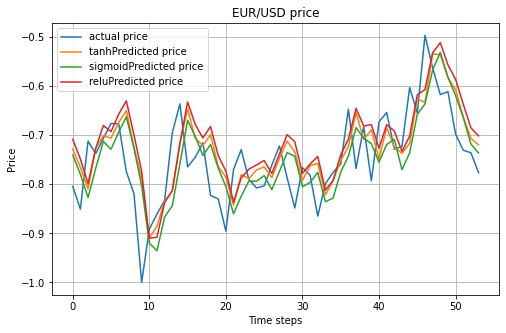



Testing df with Additional Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 17) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 17) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.370870113372803 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.6073155403137207 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.5911505222320557 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.0057063852900925294
 R2 for, tanh  =>  0.26454898309578334
.................................................
 MSE for, sigmoid  =>  0.00640905911256182
 R2 for, sigmoid  =>  0.17398689325858752
.................................................
 MSE for, relu  

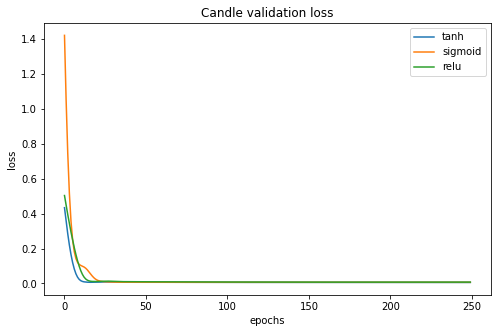


Plotting Training Loss over Epochs


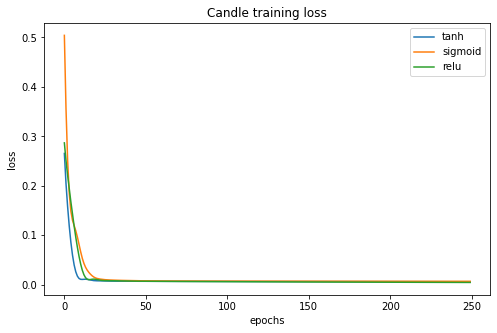

No handles with labels found to put in legend.

Plotting Best Testing Errors


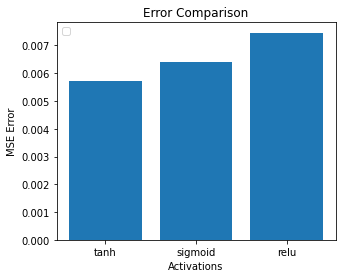


Plotting Best Testing r2
No handles with labels found to put in legend.


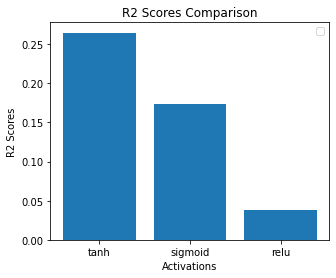


Plotting Predictions


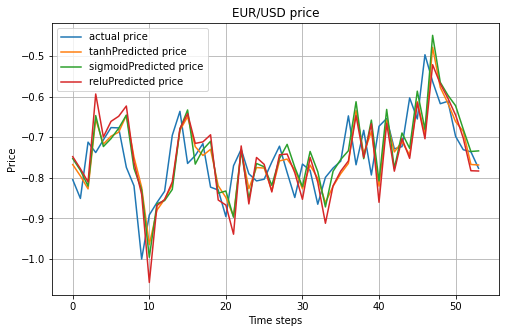



Testing df with News Title Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  3.983988046646118 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.8561761379241943 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.6058897972106934 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.006645445214605951
 R2 for, tanh  =>  0.14352095198535797
.................................................
 MSE for, sigmoid  =>  0.00634066136463462
 R2 for, sigmoid  =>  0.18280213981306637
.................................................
 MSE for, relu  =

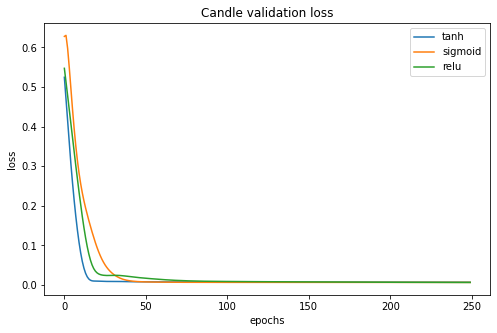


Plotting Training Loss over Epochs


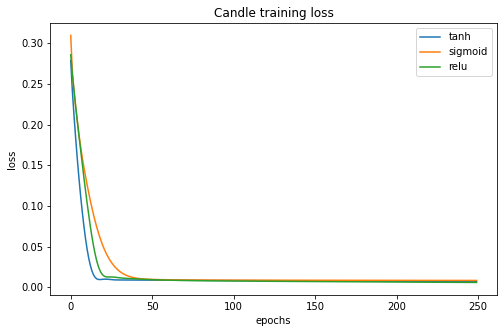

No handles with labels found to put in legend.

Plotting Best Testing Errors


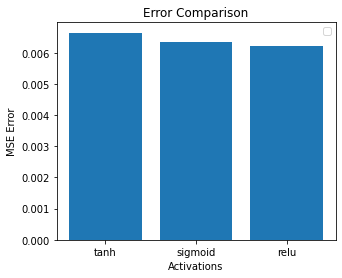

No handles with labels found to put in legend.

Plotting Best Testing r2


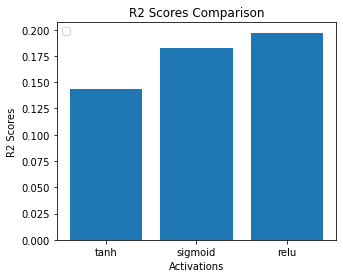


Plotting Predictions


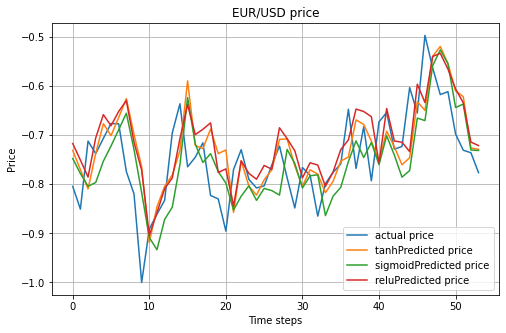



Testing df with News Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 16) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 16) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.021789073944092 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.5292160511016846 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.5359649658203125 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.007337833248321335
 R2 for, tanh  =>  0.0542845163783201
.................................................
 MSE for, sigmoid  =>  0.006371546824894457
 R2 for, sigmoid  =>  0.1788215563086386
.................................................
 MSE for, relu  =>  0.01

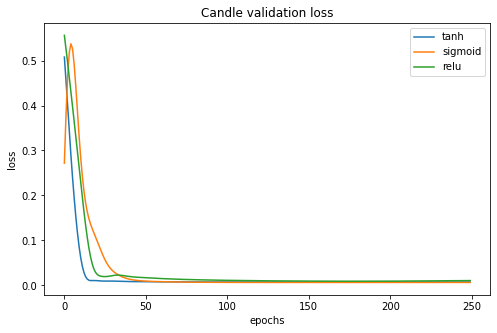


Plotting Training Loss over Epochs


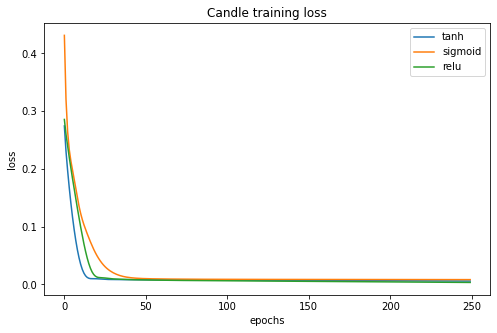

No handles with labels found to put in legend.

Plotting Best Testing Errors


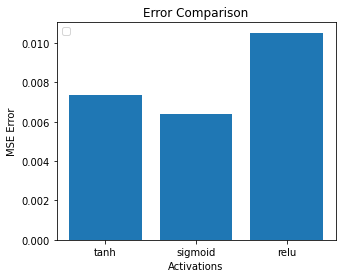


Plotting Best Testing r2
No handles with labels found to put in legend.


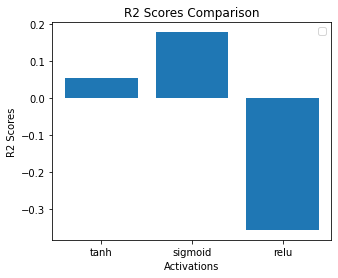


Plotting Predictions


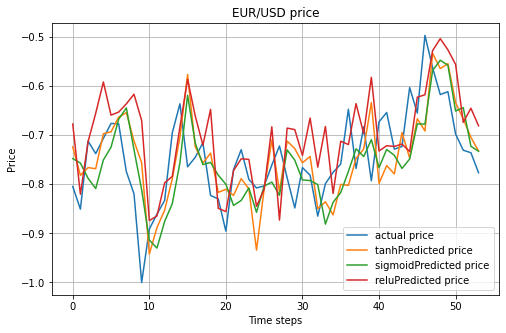



Testing df with Correlated 10% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 20) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 20) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.088524580001831 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.594646692276001 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.519472599029541 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.009266520679890426
 R2 for, tanh  =>  -0.19428880293480155
.................................................
 MSE for, sigmoid  =>  0.00697385798877398
 R2 for, sigmoid  =>  0.10119441838350651
.................................................
 MSE for, relu

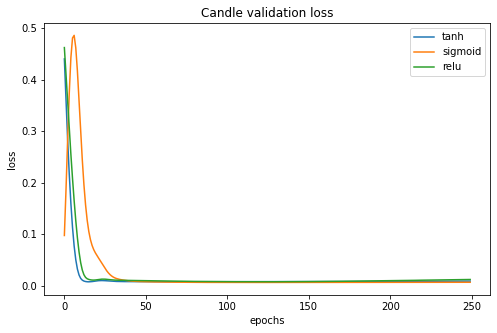


Plotting Training Loss over Epochs


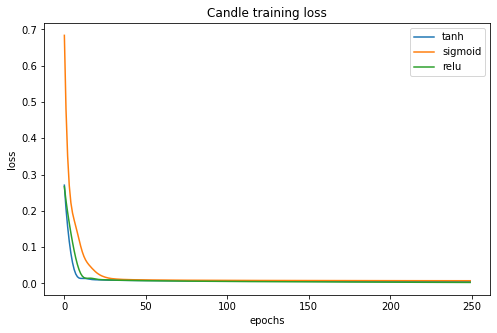

No handles with labels found to put in legend.

Plotting Best Testing Errors


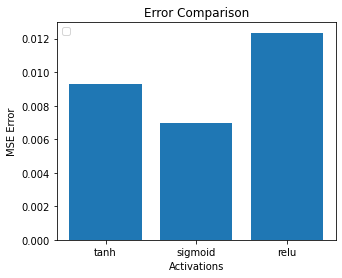

No handles with labels found to put in legend.

Plotting Best Testing r2


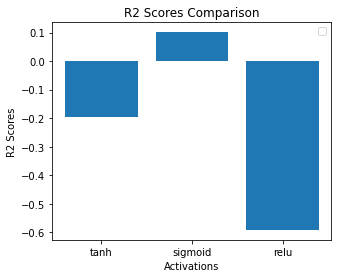


Plotting Predictions


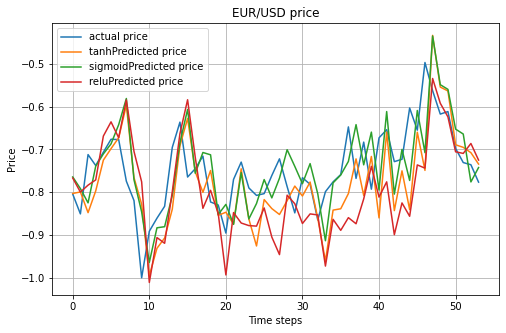



Testing df with Correlated 20% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.0607500076293945 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.980762243270874 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.6281371116638184 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.008452014173824638
 R2 for, tanh  =>  -0.08931348008002948
.................................................
 MSE for, sigmoid  =>  0.005629738002161892
 R2 for, sigmoid  =>  0.27442744783061435
.................................................
 MSE for, r

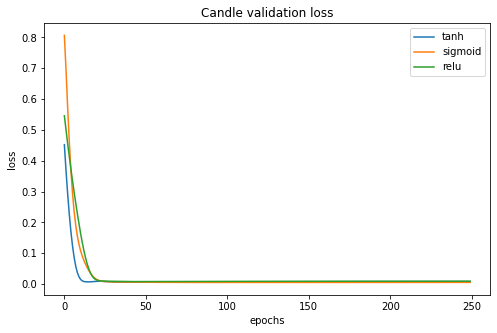


Plotting Training Loss over Epochs


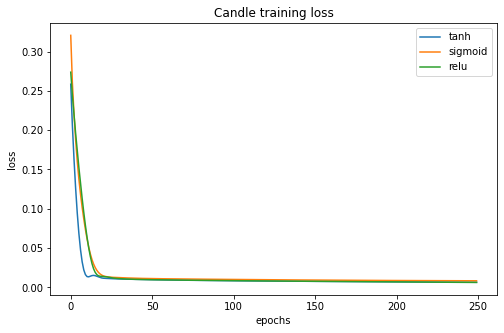

No handles with labels found to put in legend.

Plotting Best Testing Errors


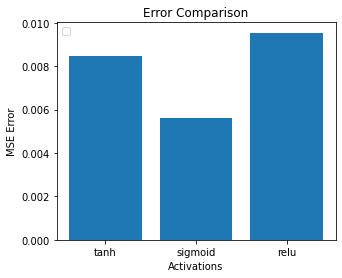

No handles with labels found to put in legend.

Plotting Best Testing r2


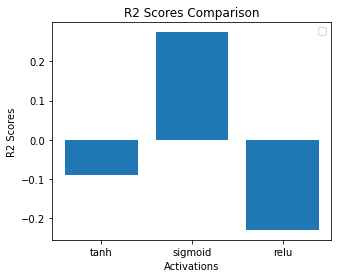


Plotting Predictions


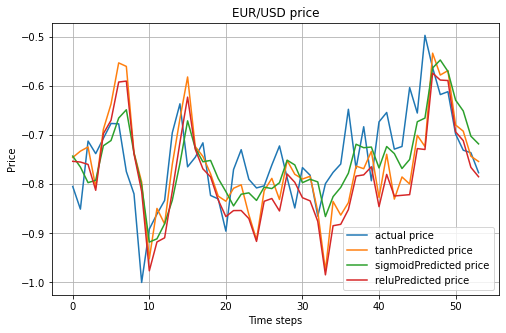



Testing df with All Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 29) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 29) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.114641427993774 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.548362970352173 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.6354610919952393 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.008281368158669894
 R2 for, tanh  =>  -0.06732026038031758
.................................................
 MSE for, sigmoid  =>  0.007880746746432412
 R2 for, sigmoid  =>  -0.01568732463459943
.................................................
 MSE for, relu  =>  0.

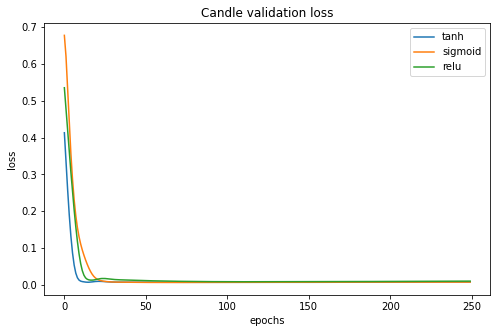


Plotting Training Loss over Epochs


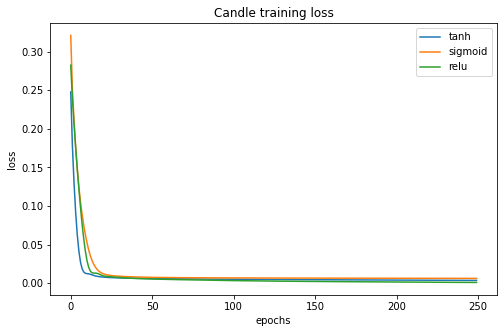

No handles with labels found to put in legend.

Plotting Best Testing Errors


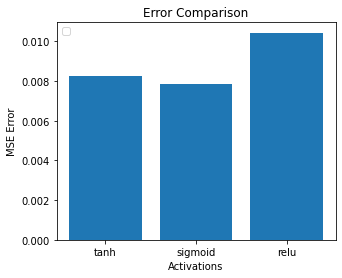

No handles with labels found to put in legend.

Plotting Best Testing r2


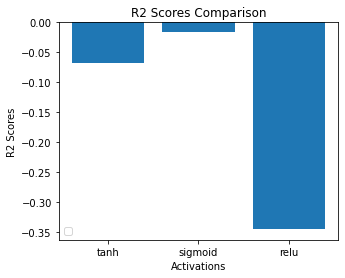


Plotting Predictions


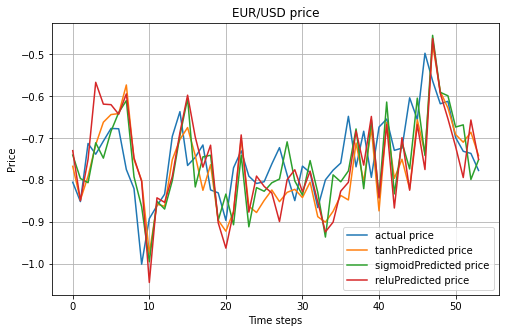

In [22]:
df = pd.read_csv('merged_data.csv',parse_dates=True,skipinitialspace=True,index_col='Date')

df_raw = df[raw_columns]
df_additional = df[forex_additional_column]
df_news = df[news_columns]
df_news_title = df[news_columns_title]
df_correlated_10 = df[correlated_10]
df_correlated_20 = df[correlated_20]
df_names =["Raw","Additional","News Title", "News","Correlated 10%","Correlated 20%", "All"]
dfs= [df_raw,df_additional,df_news_title,df_news,df_correlated_10,df_correlated_20,df]

all_losses = []
all_r2_scores = []
for name,current_df in zip(df_names,dfs):
    
    print("Testing df with",name,"Columns")

    print("\nSplitting and Creating Dataset")
    xtrain,ytrain,xtest,ytest = make_dataset(current_df)
    m = Models_FLF(activations)
    print("\nCreating and Training Models")
    m.train_all(xtrain, ytrain, units = 200, epochs = 250, verbose=0)
    print('\nEvaluating Models')
    losses,r2_scores  = m.evaluate(xtest)
    all_losses.append(losses)
    all_r2_scores.append(r2_scores)
    print("\nPlotting Testing Loss Over epochs")
    m.plot_validation_loss()
    print("\nPlotting Training Loss over Epochs")
    m.plot_train_loss()
    print("\nPlotting Best Testing Errors")
    m.plot_error(losses)
    print("\nPlotting Best Testing r2")
    m.plot_r2(r2_scores)
    print("\nPlotting Predictions")
    m.plot()
    print("\n")
    

In [23]:
# Single LSTM tokenized and stemmed
x = PrettyTable()
x.field_names = ["Columns", "Activation", "Loss", "R2"]
for name,current_loss,current_r2 in zip(df_names,all_losses,all_r2_scores):
    for act in activations:
        x.add_row([name, act, current_loss[act][0], current_r2[act][0]])
print(x)

+----------------+------------+-----------------------+----------------------+
|    Columns     | Activation |          Loss         |          R2          |
+----------------+------------+-----------------------+----------------------+
|      Raw       |    tanh    |  0.005470750254963724 |  0.2949181252749178  |
|      Raw       |  sigmoid   |  0.005626428843312729 | 0.27485393922875745  |
|      Raw       |    relu    |  0.00663078413744218  | 0.14541050264849442  |
|   Additional   |    tanh    | 0.0057063852900925294 | 0.26454898309578334  |
|   Additional   |  sigmoid   |  0.00640905911256182  | 0.17398689325858752  |
|   Additional   |    relu    |  0.007459989694632875 | 0.03854073496608201  |
|   News Title   |    tanh    |  0.006645445214605951 | 0.14352095198535797  |
|   News Title   |  sigmoid   |  0.00634066136463462  | 0.18280213981306637  |
|   News Title   |    relu    |  0.006229638839848153 |  0.197110957848057   |
|      News      |    tanh    |  0.00733783324832133

# Tokenized and Stemmed with Extra words

Testing df with Raw Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 4) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 4) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.151839017868042 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.5622050762176514 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.5355873107910156 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005490758883348548
 R2 for, tanh  =>  0.29233937088936535
.................................................
 MSE for, sigmoid  =>  0.00558002665439151
 R2 for, sigmoid  =>  0.2808343515727929
.................................................
 MSE for, relu  =>  0.0064429

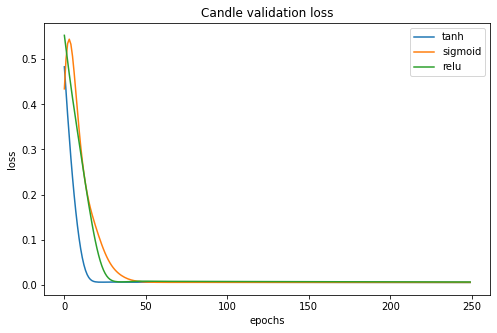


Plotting Training Loss over Epochs


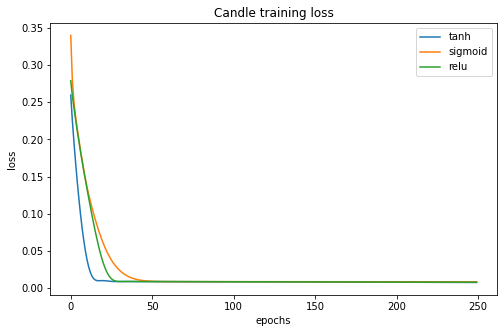

No handles with labels found to put in legend.

Plotting Best Testing Errors


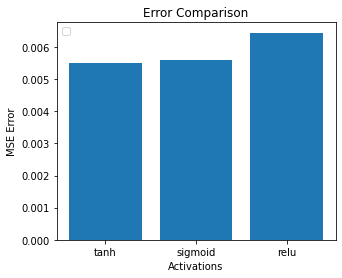

No handles with labels found to put in legend.

Plotting Best Testing r2


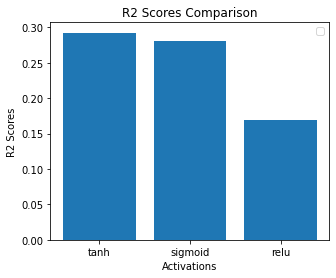


Plotting Predictions


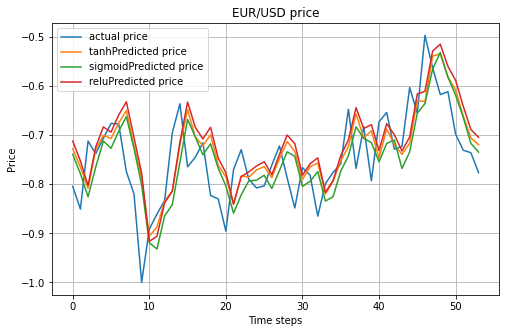



Testing df with Additional Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 17) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 17) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.037381172180176 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.5117082595825195 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.9955546855926514 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005657915909914729
 R2 for, tanh  =>  0.2707958194253195
.................................................
 MSE for, sigmoid  =>  0.006409228616869876
 R2 for, sigmoid  =>  0.17396504718451578
.................................................
 MSE for, relu  =

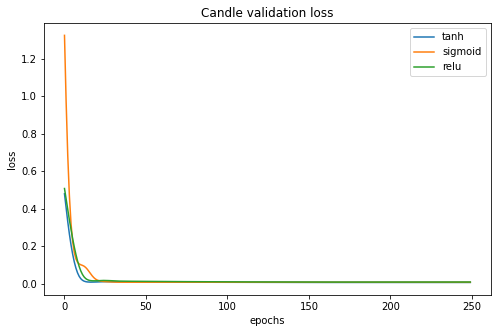


Plotting Training Loss over Epochs


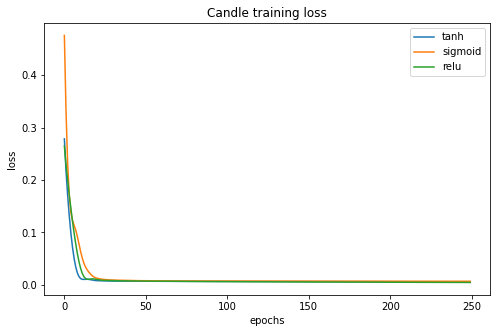

No handles with labels found to put in legend.

Plotting Best Testing Errors


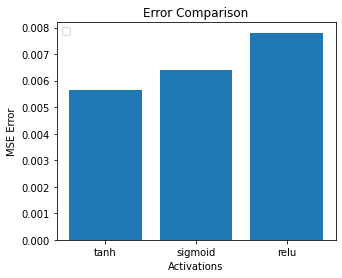

No handles with labels found to put in legend.

Plotting Best Testing r2


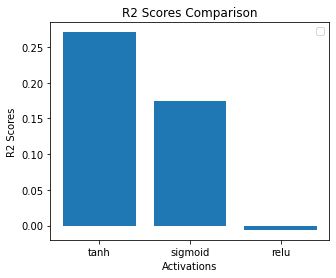


Plotting Predictions


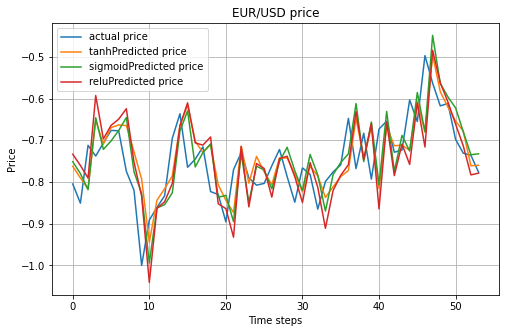



Testing df with News Title Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.434152603149414 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  4.0246617794036865 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.801785945892334 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.007321855526473733
 R2 for, tanh  =>  0.05634375899571464
.................................................
 MSE for, sigmoid  =>  0.006845743698348913
 R2 for, sigmoid  =>  0.11770605935816458
.................................................
 MSE for, relu  =

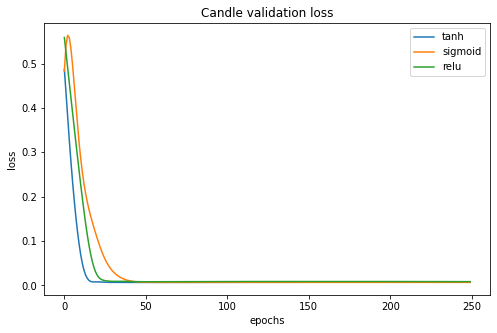


Plotting Training Loss over Epochs


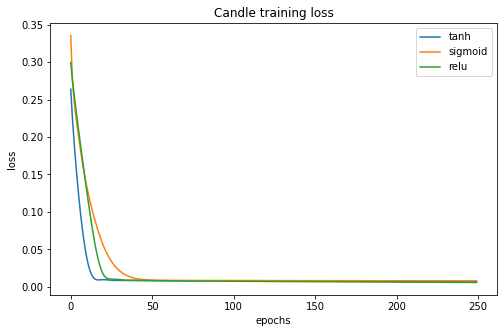

No handles with labels found to put in legend.

Plotting Best Testing Errors


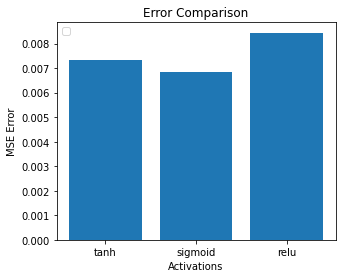

No handles with labels found to put in legend.

Plotting Best Testing r2


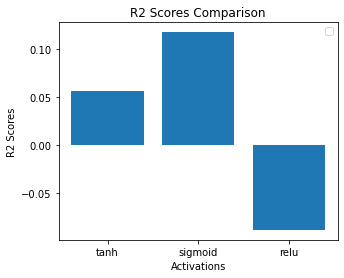


Plotting Predictions


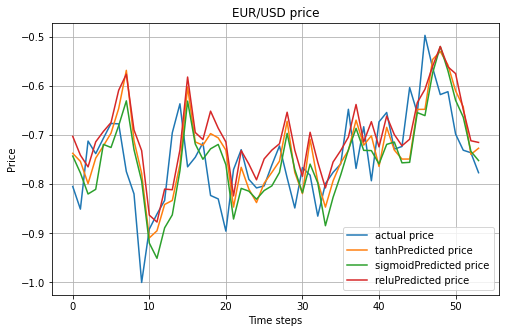



Testing df with News Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 16) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 16) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.420450210571289 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.915365219116211 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.9739813804626465 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.009765610277361211
 R2 for, tanh  =>  -0.2586125268557029
.................................................
 MSE for, sigmoid  =>  0.006880531729096496
 R2 for, sigmoid  =>  0.11322250430732961
.................................................
 MSE for, relu  =>  0.0

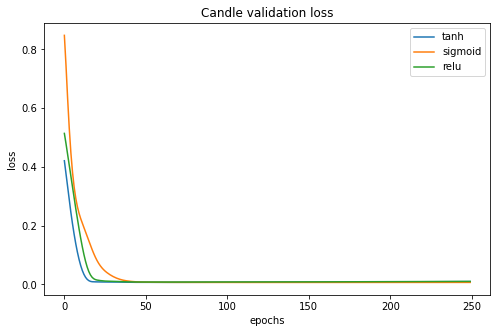


Plotting Training Loss over Epochs


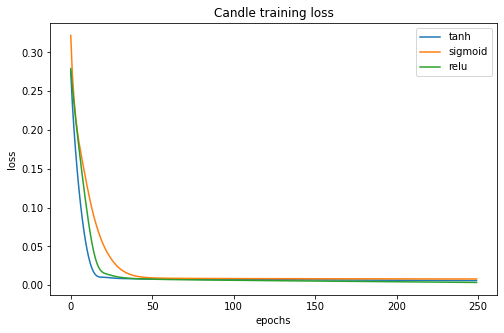

No handles with labels found to put in legend.

Plotting Best Testing Errors


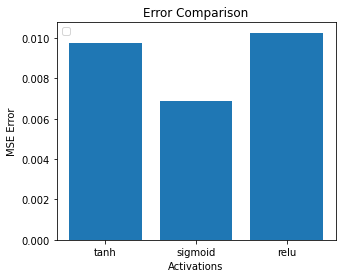

No handles with labels found to put in legend.

Plotting Best Testing r2


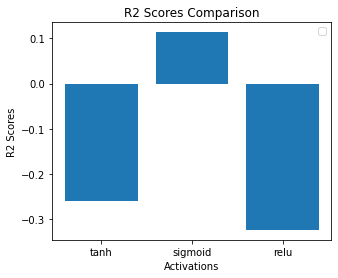


Plotting Predictions


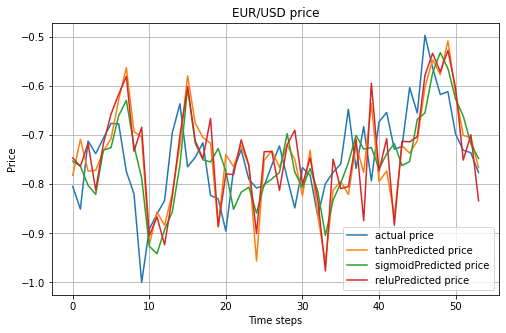



Testing df with Correlated 10% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 20) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 20) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.422888994216919 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  4.1007981300354 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.948179006576538 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.009158188537968657
 R2 for, tanh  =>  -0.18032672713909492
.................................................
 MSE for, sigmoid  =>  0.0074121969301427434
 R2 for, sigmoid  =>  0.04470036763336038
.................................................
 MSE for, relu

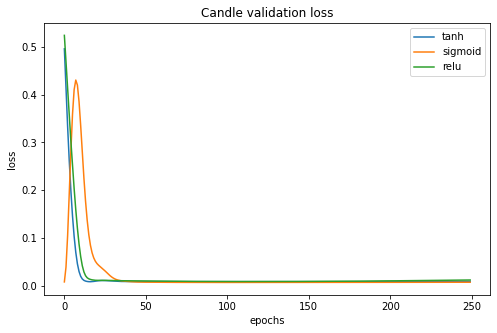


Plotting Training Loss over Epochs


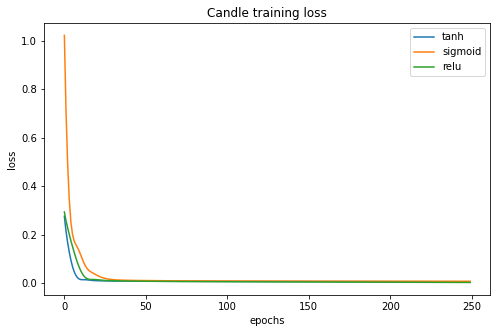

No handles with labels found to put in legend.

Plotting Best Testing Errors


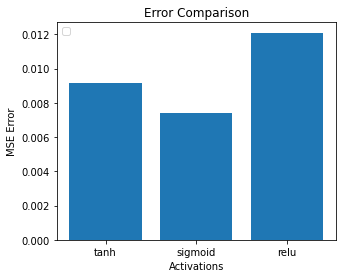

No handles with labels found to put in legend.

Plotting Best Testing r2


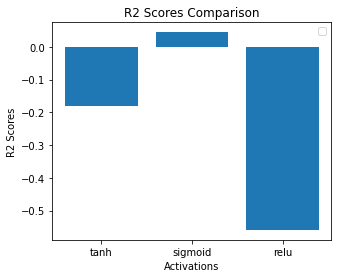


Plotting Predictions


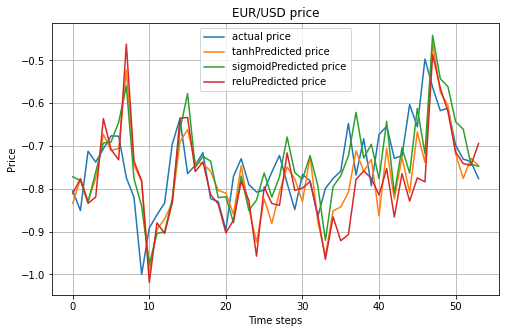



Testing df with Correlated 20% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.557701826095581 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.8637657165527344 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.8871140480041504 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.008364995940576466
 R2 for, tanh  =>  -0.07809838595683938
.................................................
 MSE for, sigmoid  =>  0.005646479992110495
 R2 for, sigmoid  =>  0.2722697047223672
.................................................
 MSE for, re

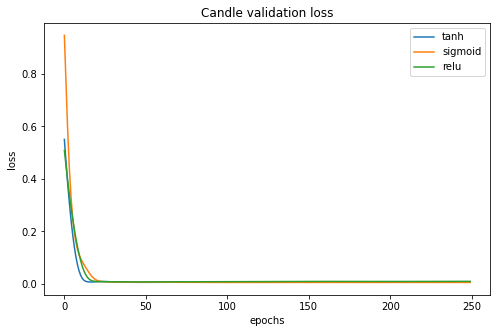


Plotting Training Loss over Epochs


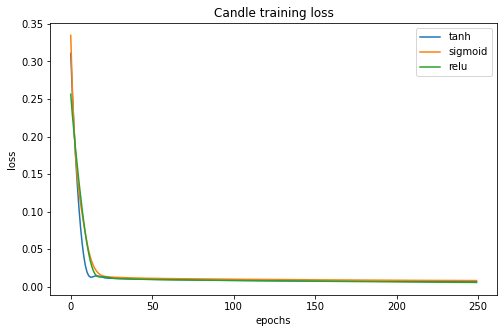

No handles with labels found to put in legend.

Plotting Best Testing Errors


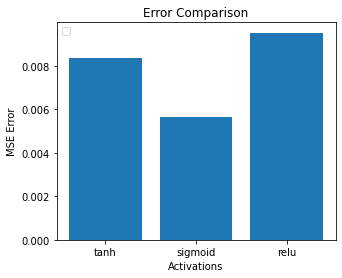

No handles with labels found to put in legend.

Plotting Best Testing r2


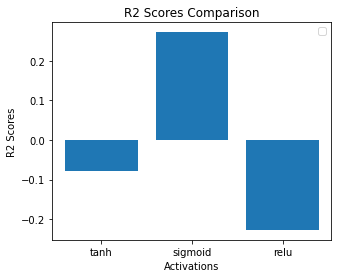


Plotting Predictions


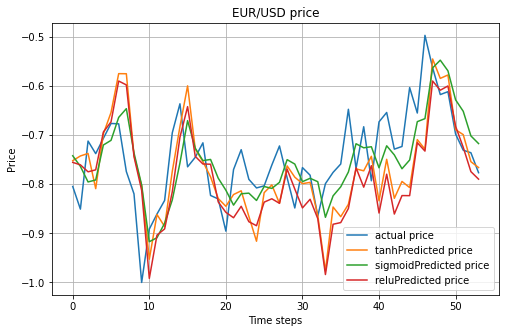



Testing df with All Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 29) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 29) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.295993089675903 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.836381196975708 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  4.29765510559082 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.009864427921759705
 R2 for, tanh  =>  -0.27134835406791935
.................................................
 MSE for, sigmoid  =>  0.0073968066881440085
 R2 for, sigmoid  =>  0.04668389460410727
.................................................
 MSE for, relu  =>  0.01

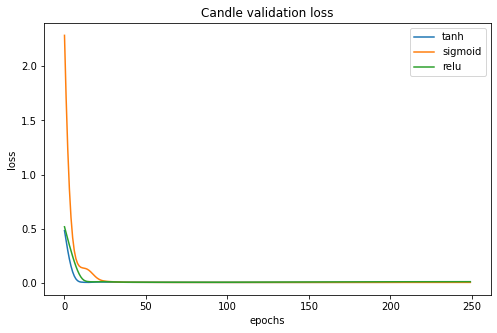


Plotting Training Loss over Epochs


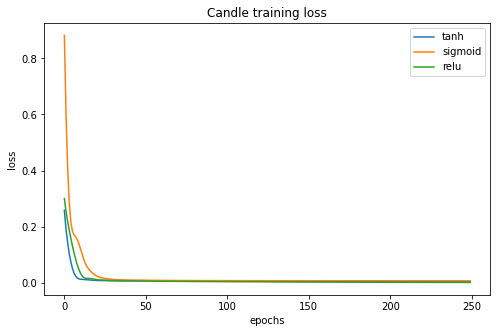

No handles with labels found to put in legend.

Plotting Best Testing Errors


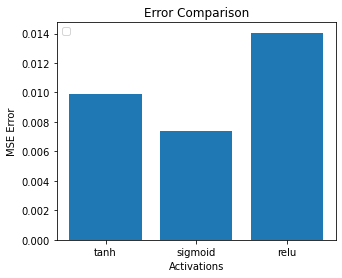

No handles with labels found to put in legend.

Plotting Best Testing r2


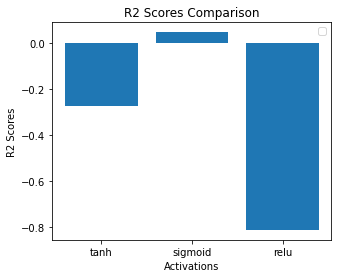


Plotting Predictions


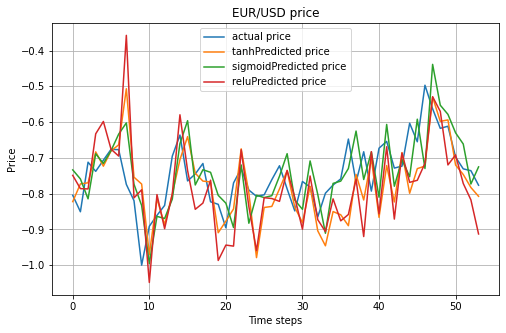

In [24]:
df = pd.read_csv('merged_data_extra.csv',parse_dates=True,skipinitialspace=True,index_col='Date')

df_raw = df[raw_columns]
df_additional = df[forex_additional_column]
df_news = df[news_columns]
df_news_title = df[news_columns_title]
df_correlated_10 = df[correlated_10]
df_correlated_20 = df[correlated_20]
df_names =["Raw","Additional","News Title", "News","Correlated 10%","Correlated 20%", "All"]
dfs= [df_raw,df_additional,df_news_title,df_news,df_correlated_10,df_correlated_20,df]

all_losses = []
all_r2_scores = []
for name,current_df in zip(df_names,dfs):
    
    print("Testing df with",name,"Columns")

    print("\nSplitting and Creating Dataset")
    xtrain,ytrain,xtest,ytest = make_dataset(current_df)
    m = Models_FLF(activations)
    print("\nCreating and Training Models")
    m.train_all(xtrain, ytrain, units = 200, epochs = 250, verbose=0)
    print('\nEvaluating Models')
    losses,r2_scores  = m.evaluate(xtest)
    all_losses.append(losses)
    all_r2_scores.append(r2_scores)
    print("\nPlotting Testing Loss Over epochs")
    m.plot_validation_loss()
    print("\nPlotting Training Loss over Epochs")
    m.plot_train_loss()
    print("\nPlotting Best Testing Errors")
    m.plot_error(losses)
    print("\nPlotting Best Testing r2")
    m.plot_r2(r2_scores)
    print("\nPlotting Predictions")
    m.plot()
    print("\n")
    

In [25]:
# Single LSTM tokenized and stemmed with Extra words
x = PrettyTable()
x.field_names = ["Columns", "Activation", "Loss", "R2"]
for name,current_loss,current_r2 in zip(df_names,all_losses,all_r2_scores):
    for act in activations:
        x.add_row([name, act, current_loss[act][0], current_r2[act][0]])
print(x)

+----------------+------------+-----------------------+-----------------------+
|    Columns     | Activation |          Loss         |           R2          |
+----------------+------------+-----------------------+-----------------------+
|      Raw       |    tanh    |  0.005490758883348548 |  0.29233937088936535  |
|      Raw       |  sigmoid   |  0.00558002665439151  |   0.2808343515727929  |
|      Raw       |    relu    |  0.006442916980736088 |   0.1696232195294043  |
|   Additional   |    tanh    |  0.005657915909914729 |   0.2707958194253195  |
|   Additional   |  sigmoid   |  0.006409228616869876 |  0.17396504718451578  |
|   Additional   |    relu    |  0.007806727448101293 | -0.006147560762946425 |
|   News Title   |    tanh    |  0.007321855526473733 |  0.05634375899571464  |
|   News Title   |  sigmoid   |  0.006845743698348913 |  0.11770605935816458  |
|   News Title   |    relu    |  0.008442746404995758 |  -0.08811903041301083 |
|      News      |    tanh    |  0.00976

# Tokenized Only

Testing df with Raw Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 4) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 4) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.3801233768463135 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.5983338356018066 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.574445962905884 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005491848226757629
 R2 for, tanh  =>  0.2921989740046058
.................................................
 MSE for, sigmoid  =>  0.005616207094403827
 R2 for, sigmoid  =>  0.2761713398681155
.................................................
 MSE for, relu  =>  0.0066470

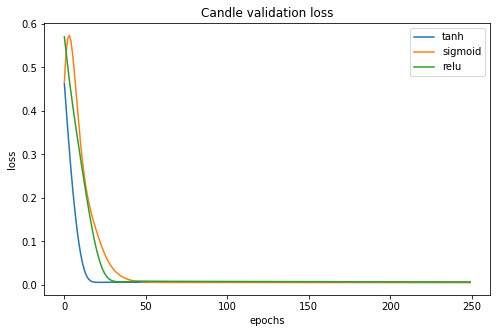


Plotting Training Loss over Epochs


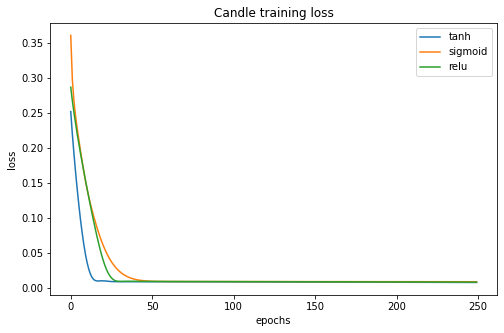

No handles with labels found to put in legend.

Plotting Best Testing Errors


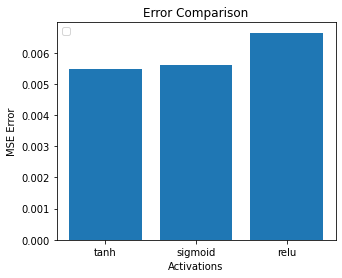

No handles with labels found to put in legend.

Plotting Best Testing r2


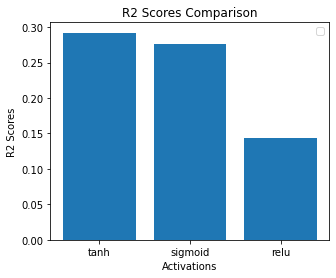


Plotting Predictions


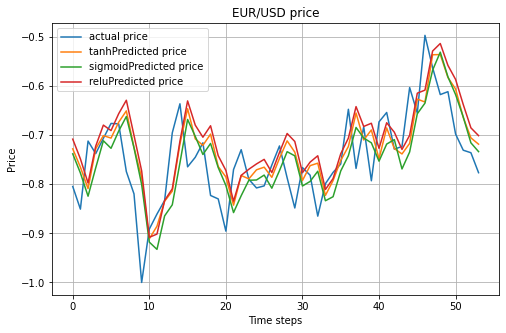



Testing df with Additional Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 17) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 17) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.048436641693115 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  4.386495590209961 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.967573404312134 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.006022274464264512
 R2 for, tanh  =>  0.22383651757454082
.................................................
 MSE for, sigmoid  =>  0.006403644382006091
 R2 for, sigmoid  =>  0.17468475519587856
.................................................
 MSE for, relu  =>

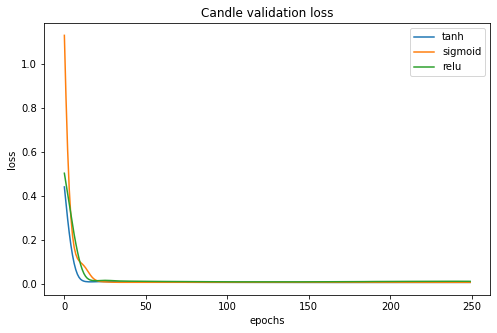


Plotting Training Loss over Epochs


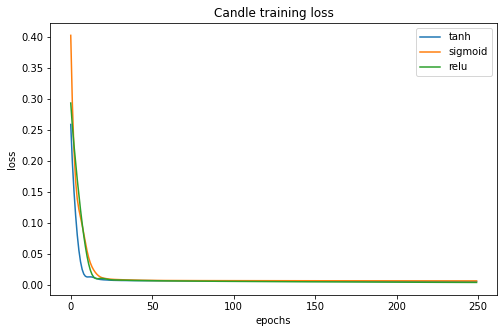

No handles with labels found to put in legend.

Plotting Best Testing Errors


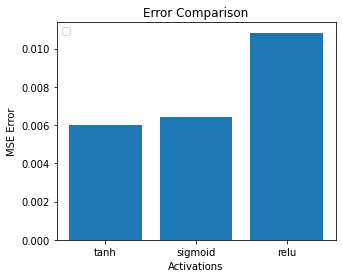


Plotting Best Testing r2
No handles with labels found to put in legend.


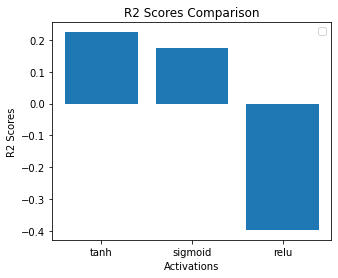


Plotting Predictions


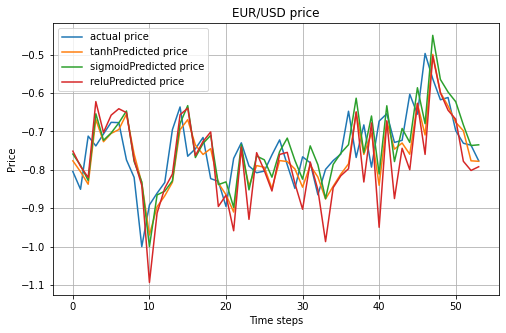



Testing df with News Title Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.289111852645874 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.8050076961517334 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.821709394454956 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.006863676566523171
 R2 for, tanh  =>  0.11539483334304323
.................................................
 MSE for, sigmoid  =>  0.006084853036727368
 R2 for, sigmoid  =>  0.2157712586734064
.................................................
 MSE for, relu  =>

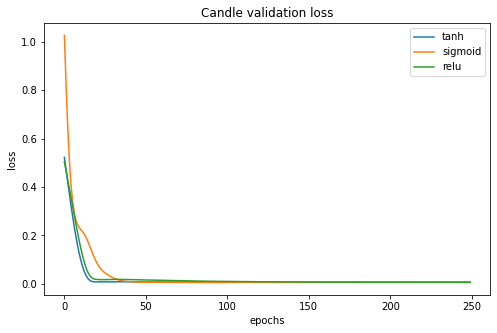


Plotting Training Loss over Epochs


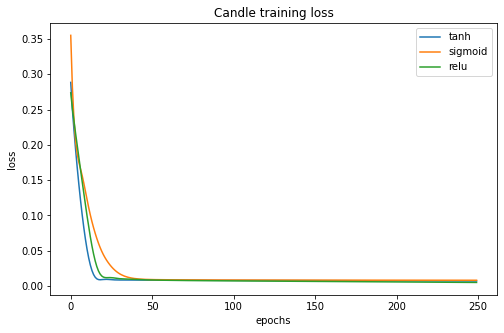

No handles with labels found to put in legend.

Plotting Best Testing Errors


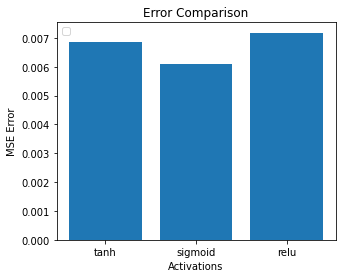

No handles with labels found to put in legend.

Plotting Best Testing r2


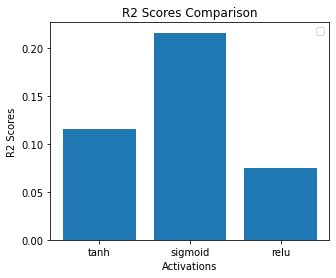


Plotting Predictions


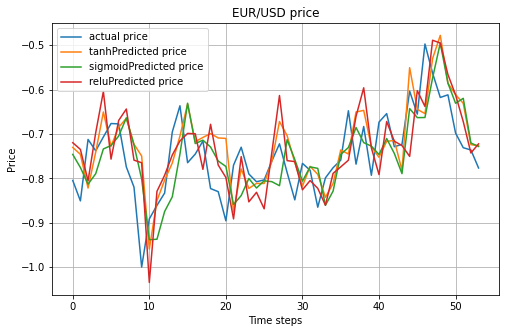



Testing df with News Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 16) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 16) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.723257064819336 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.878964424133301 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.8182575702667236 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.007394624911916129
 R2 for, tanh  =>  0.04696508654329101
.................................................
 MSE for, sigmoid  =>  0.006225411205900506
 R2 for, sigmoid  =>  0.19765582426135264
.................................................
 MSE for, relu  =>  0.0

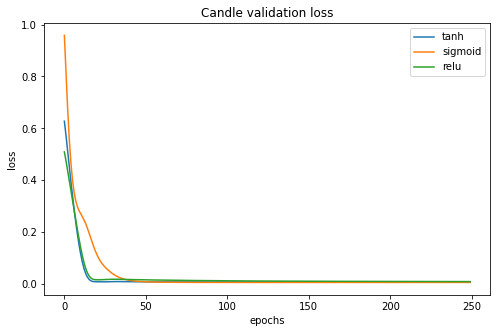


Plotting Training Loss over Epochs


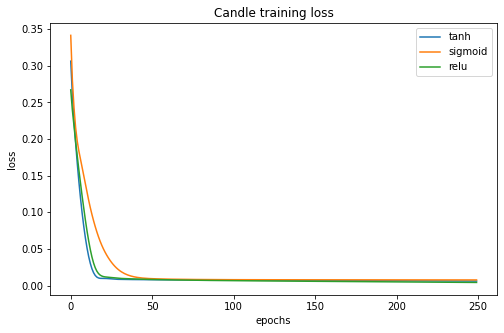

No handles with labels found to put in legend.

Plotting Best Testing Errors


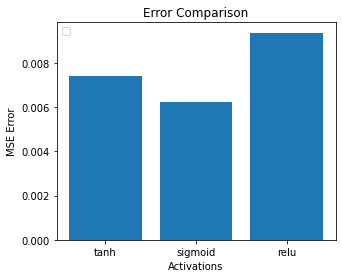


Plotting Best Testing r2
No handles with labels found to put in legend.


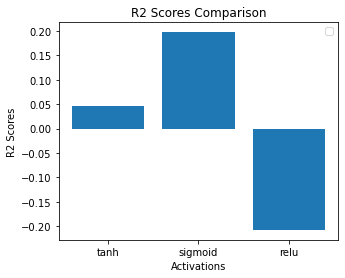


Plotting Predictions


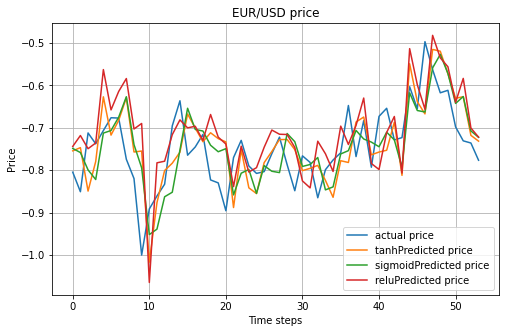



Testing df with Correlated 10% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 20) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 20) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.280135631561279 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.8105015754699707 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.841977834701538 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.007758965727649608
 R2 for, tanh  =>  8.070882935307111e-06
.................................................
 MSE for, sigmoid  =>  0.006632186962171513
 R2 for, sigmoid  =>  0.1452297036275244
.................................................
 MSE for, re

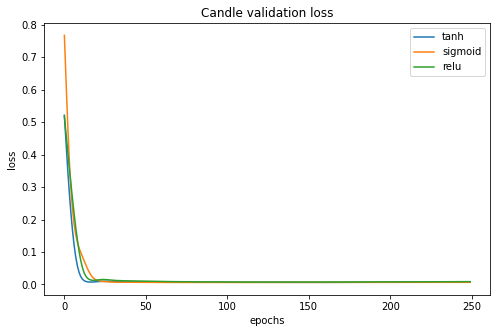


Plotting Training Loss over Epochs


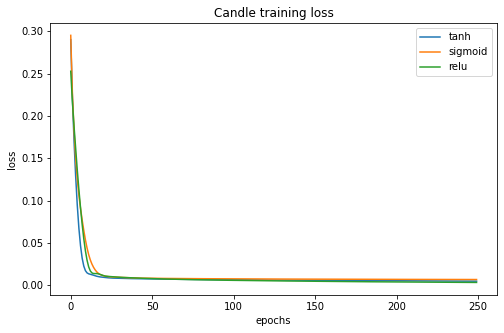

No handles with labels found to put in legend.

Plotting Best Testing Errors


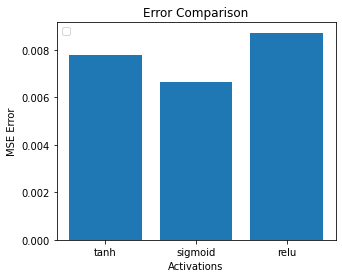

No handles with labels found to put in legend.

Plotting Best Testing r2


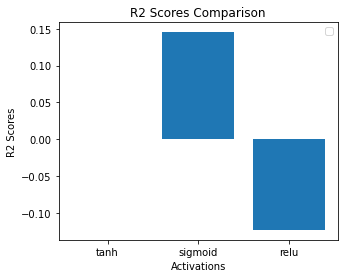


Plotting Predictions


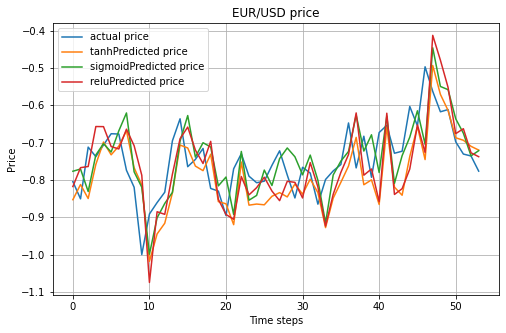



Testing df with Correlated 20% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.27568793296814 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.797788143157959 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  4.14213752746582 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.0055319831281985315
 R2 for, tanh  =>  0.28702630293921005
.................................................
 MSE for, sigmoid  =>  0.005314748421539882
 R2 for, sigmoid  =>  0.3150239718306497
.................................................
 MSE for, relu  

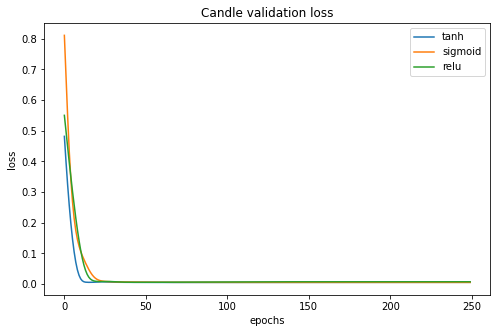


Plotting Training Loss over Epochs


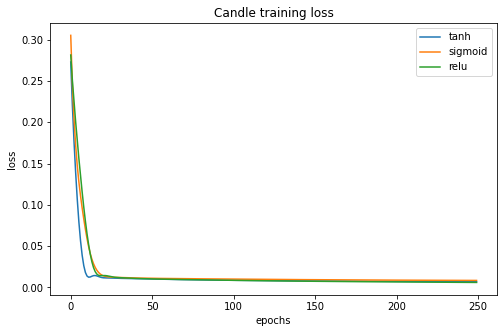

No handles with labels found to put in legend.

Plotting Best Testing Errors


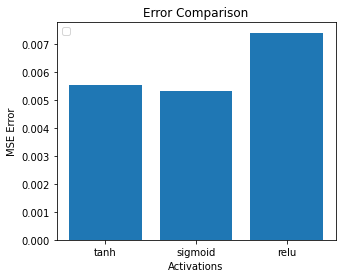

No handles with labels found to put in legend.

Plotting Best Testing r2


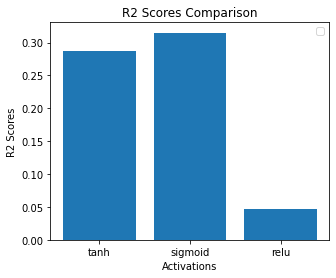


Plotting Predictions


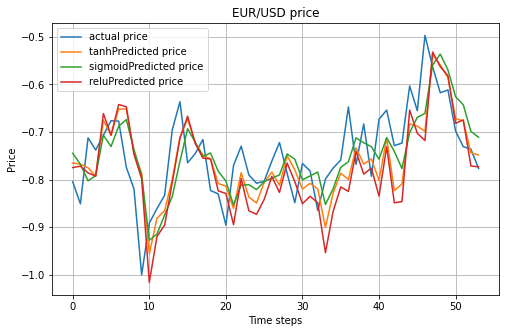



Testing df with All Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 29) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 29) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.358370065689087 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.830045223236084 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  4.379648685455322 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.007632854668678147
 R2 for, tanh  =>  0.016261531146906427
.................................................
 MSE for, sigmoid  =>  0.006712489422106968
 R2 for, sigmoid  =>  0.13488015258652153
.................................................
 MSE for, relu  =>  0.01

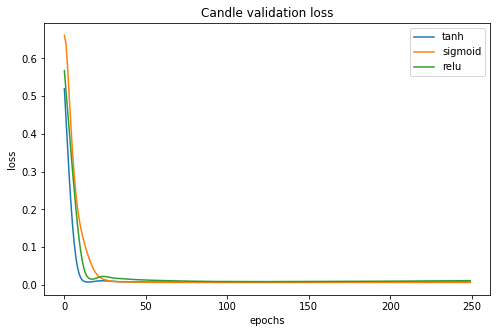


Plotting Training Loss over Epochs


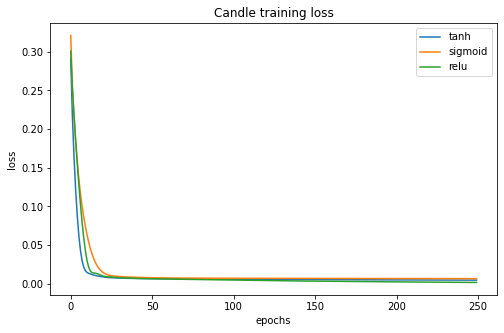

No handles with labels found to put in legend.

Plotting Best Testing Errors


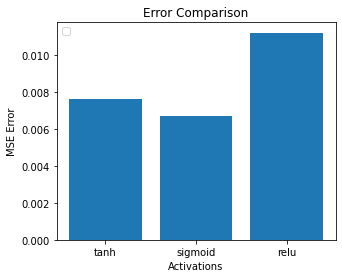


Plotting Best Testing r2
No handles with labels found to put in legend.


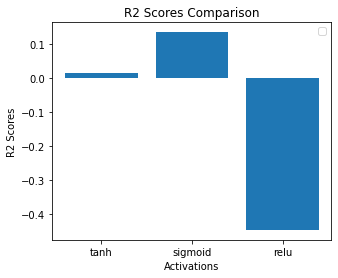


Plotting Predictions


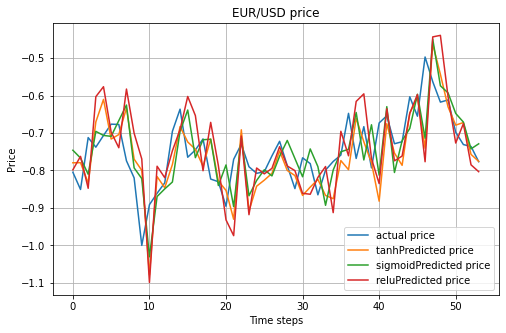

In [26]:
df = pd.read_csv('merged_data_tokenized.csv',parse_dates=True,skipinitialspace=True,index_col='Date')

df_raw = df[raw_columns]
df_additional = df[forex_additional_column]
df_news = df[news_columns]
df_news_title = df[news_columns_title]
df_correlated_10 = df[correlated_10]
df_correlated_20 = df[correlated_20]
df_names =["Raw","Additional","News Title", "News","Correlated 10%","Correlated 20%", "All"]
dfs= [df_raw,df_additional,df_news_title,df_news,df_correlated_10,df_correlated_20,df]

all_losses = []
all_r2_scores = []
for name,current_df in zip(df_names,dfs):
    
    print("Testing df with",name,"Columns")

    print("\nSplitting and Creating Dataset")
    xtrain,ytrain,xtest,ytest = make_dataset(current_df)
    m = Models_FLF(activations)
    print("\nCreating and Training Models")
    m.train_all(xtrain, ytrain, units = 200, epochs = 250, verbose=0)
    print('\nEvaluating Models')
    losses,r2_scores  = m.evaluate(xtest)
    all_losses.append(losses)
    all_r2_scores.append(r2_scores)
    print("\nPlotting Testing Loss Over epochs")
    m.plot_validation_loss()
    print("\nPlotting Training Loss over Epochs")
    m.plot_train_loss()
    print("\nPlotting Best Testing Errors")
    m.plot_error(losses)
    print("\nPlotting Best Testing r2")
    m.plot_r2(r2_scores)
    print("\nPlotting Predictions")
    m.plot()
    print("\n")
    

In [27]:
# Single LSTM tokenized only
x = PrettyTable()
x.field_names = ["Columns", "Activation", "Loss", "R2"]
for name,current_loss,current_r2 in zip(df_names,all_losses,all_r2_scores):
    for act in activations:
        x.add_row([name, act, current_loss[act][0], current_r2[act][0]])
print(x)

+----------------+------------+-----------------------+-----------------------+
|    Columns     | Activation |          Loss         |           R2          |
+----------------+------------+-----------------------+-----------------------+
|      Raw       |    tanh    |  0.005491848226757629 |   0.2921989740046058  |
|      Raw       |  sigmoid   |  0.005616207094403827 |   0.2761713398681155  |
|      Raw       |    relu    |  0.006647051640594806 |  0.14331391240302627  |
|   Additional   |    tanh    |  0.006022274464264512 |  0.22383651757454082  |
|   Additional   |  sigmoid   |  0.006403644382006091 |  0.17468475519587856  |
|   Additional   |    relu    |  0.010832832432771472 |  -0.39615837761028105 |
|   News Title   |    tanh    |  0.006863676566523171 |  0.11539483334304323  |
|   News Title   |  sigmoid   |  0.006084853036727368 |   0.2157712586734064  |
|   News Title   |    relu    |  0.007182189008305492 |  0.07434427553858514  |
|      News      |    tanh    |  0.00739

# Tokenized only with extra words

Testing df with Raw Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 4) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 4) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.3992955684661865 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.6356000900268555 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.567967176437378 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005525497951067205
 R2 for, tanh  =>  0.28786212629735564
.................................................
 MSE for, sigmoid  =>  0.005650723340952829
 R2 for, sigmoid  =>  0.271722812940175
.................................................
 MSE for, relu  =>  0.0067140

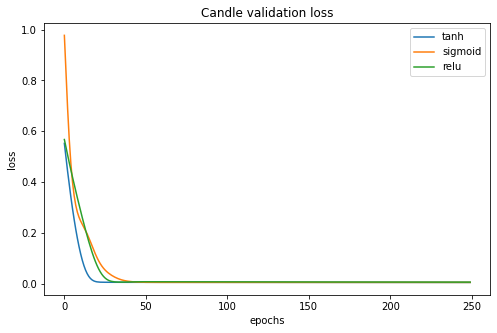


Plotting Training Loss over Epochs


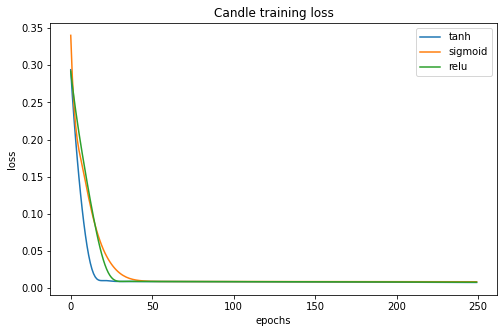

No handles with labels found to put in legend.

Plotting Best Testing Errors


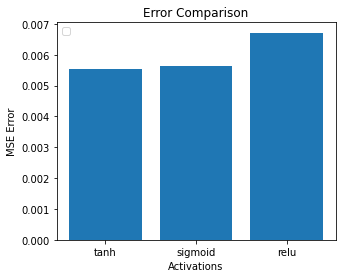


Plotting Best Testing r2
No handles with labels found to put in legend.


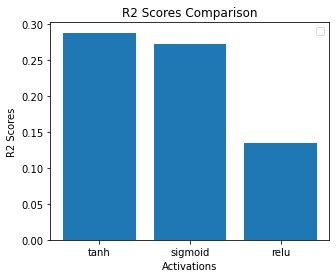


Plotting Predictions


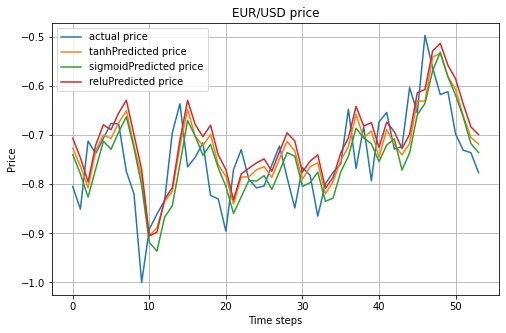



Testing df with Additional Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 17) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 17) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.007911682128906 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  4.0244317054748535 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.655972957611084 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.006282842246682145
 R2 for, tanh  =>  0.19025399014088806
.................................................
 MSE for, sigmoid  =>  0.006376648444796705
 R2 for, sigmoid  =>  0.17816404873523983
.................................................
 MSE for, relu  =

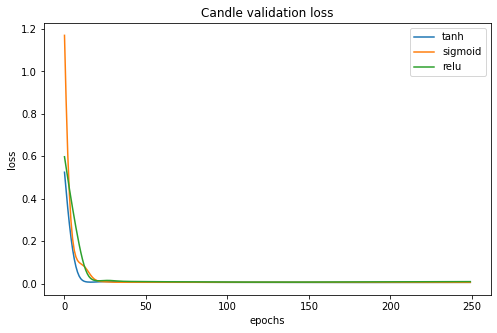


Plotting Training Loss over Epochs


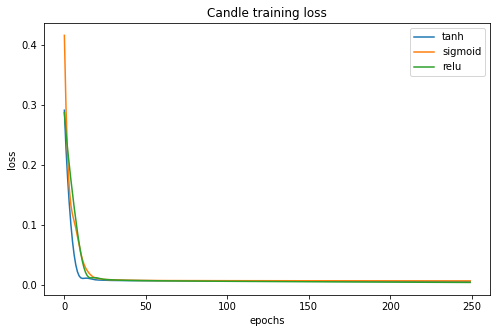

No handles with labels found to put in legend.

Plotting Best Testing Errors


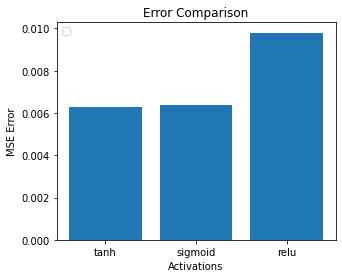


Plotting Best Testing r2
No handles with labels found to put in legend.


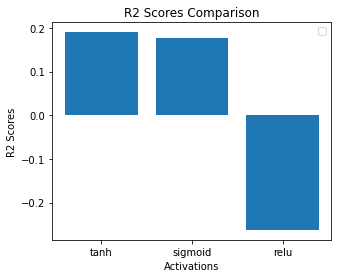


Plotting Predictions


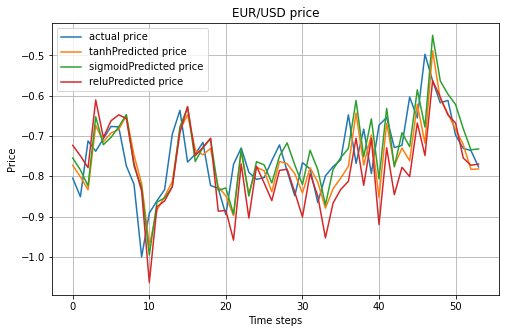



Testing df with News Title Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.054269790649414 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.5990231037139893 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.5955891609191895 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005412386567270424
 R2 for, tanh  =>  0.30244016090381964
.................................................
 MSE for, sigmoid  =>  0.006554129098459591
 R2 for, sigmoid  =>  0.15528996635531045
.................................................
 MSE for, relu  

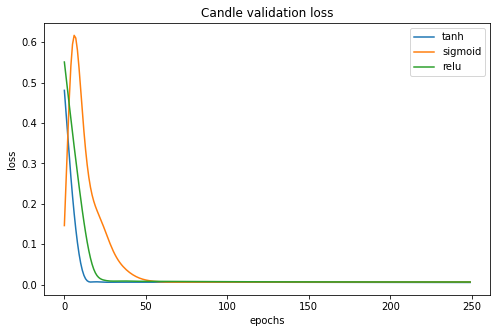


Plotting Training Loss over Epochs


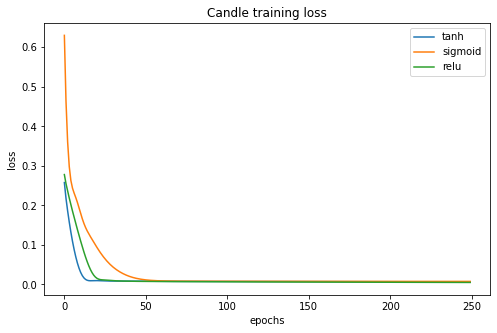

No handles with labels found to put in legend.

Plotting Best Testing Errors


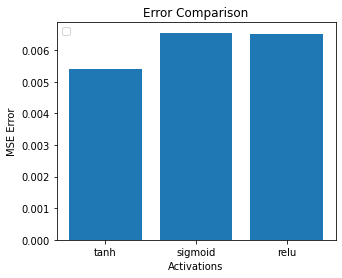

No handles with labels found to put in legend.

Plotting Best Testing r2


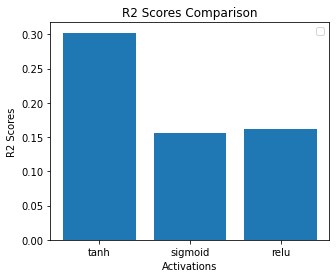


Plotting Predictions


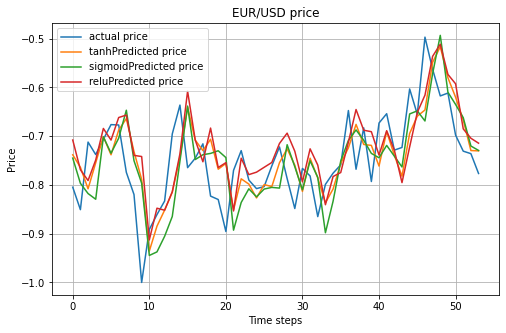



Testing df with News Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 16) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 16) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.356045484542847 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  4.464394569396973 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  4.134955644607544 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.005967829784779022
 R2 for, tanh  =>  0.23085346312887411
.................................................
 MSE for, sigmoid  =>  0.0064181432981704
 R2 for, sigmoid  =>  0.17281610418565607
.................................................
 MSE for, relu  =>  0.0066

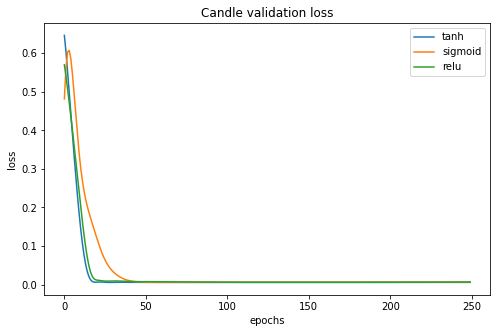


Plotting Training Loss over Epochs


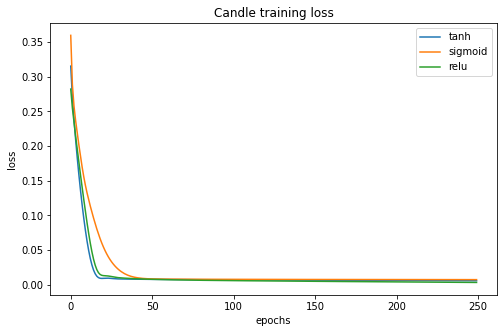

No handles with labels found to put in legend.

Plotting Best Testing Errors


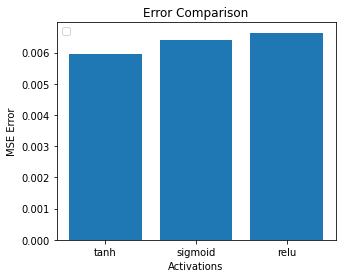

No handles with labels found to put in legend.

Plotting Best Testing r2


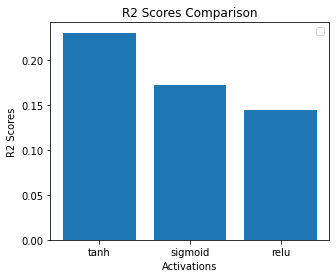


Plotting Predictions


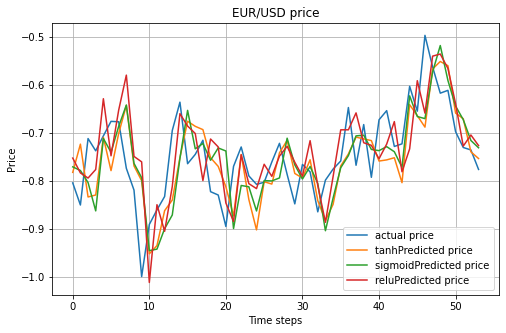



Testing df with Correlated 10% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 20) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 20) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.319255828857422 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.8316309452056885 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.8462886810302734 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.007217818922091593
 R2 for, tanh  =>  0.06975221681943533
.................................................
 MSE for, sigmoid  =>  0.006923930363403459
 R2 for, sigmoid  =>  0.10762919644066204
.................................................
 MSE for, re

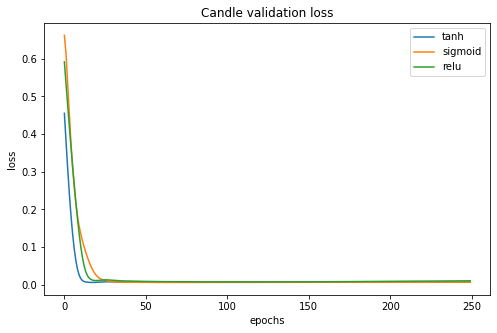


Plotting Training Loss over Epochs


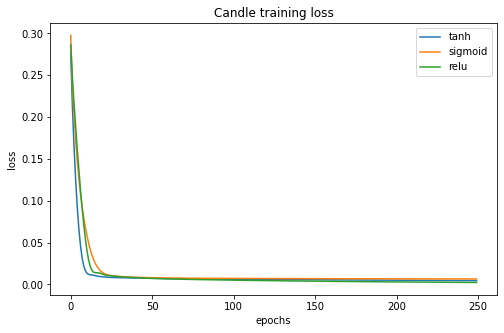

No handles with labels found to put in legend.

Plotting Best Testing Errors


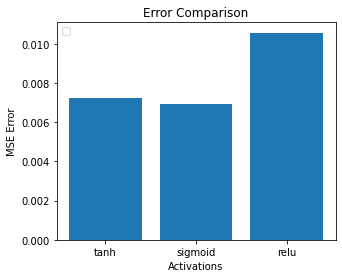

No handles with labels found to put in legend.

Plotting Best Testing r2


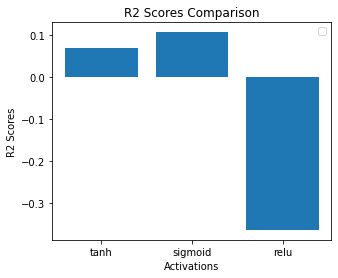


Plotting Predictions


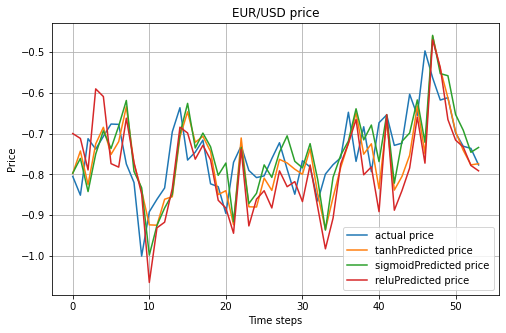



Testing df with Correlated 20% Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 10) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 10) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.293987274169922 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  4.385087251663208 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.9006683826446533 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.006296748537839692
 R2 for, tanh  =>  0.1884617178961554
.................................................
 MSE for, sigmoid  =>  0.00528483642675437
 R2 for, sigmoid  =>  0.3188790930438691
.................................................
 MSE for, relu  

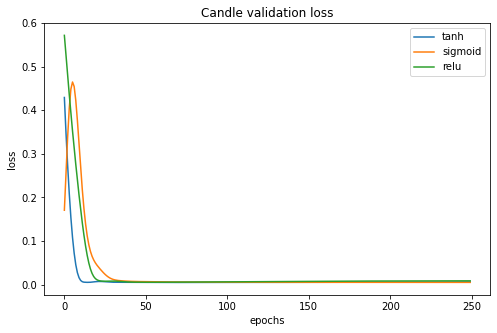


Plotting Training Loss over Epochs


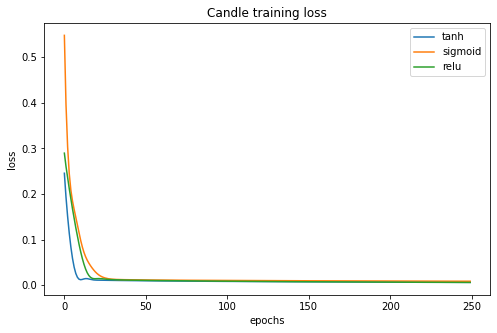

No handles with labels found to put in legend.

Plotting Best Testing Errors


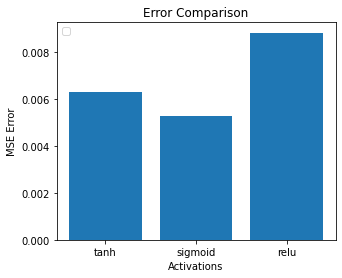

No handles with labels found to put in legend.

Plotting Best Testing r2


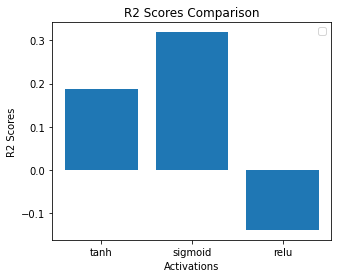


Plotting Predictions


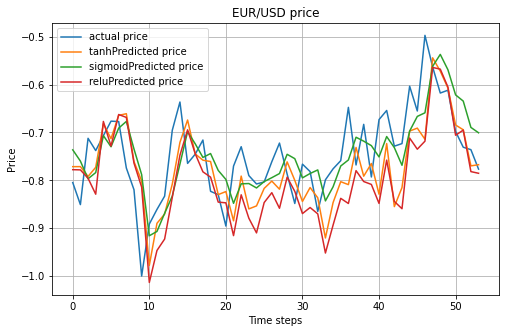



Testing df with All Columns

Splitting and Creating Dataset
Number of records in Training Data: 216
Number of records in Test Data: 56
Number of rows and columns in the Training set X: (216, 1, 29) and y: (216, 1)
Number of rows and columns in the Test set X: (55, 1, 29) and y: (55, 1)

Creating and Training Models
done training model with activation tanh    1 / 3 completed.
time of execution =  4.334719896316528 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  3.8390541076660156 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  3.8550546169281006 seconds

Evaluating Models
predicting candles and evaluating models...
 MSE for, tanh  =>  0.006940464744028536
 R2 for, tanh  =>  0.10549821046155072
.................................................
 MSE for, sigmoid  =>  0.006717088511460319
 R2 for, sigmoid  =>  0.1342874122141482
.................................................
 MSE for, relu  =>  0.01

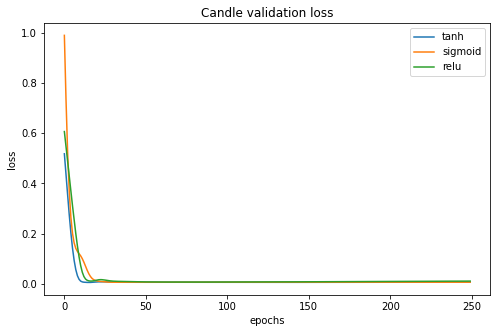


Plotting Training Loss over Epochs


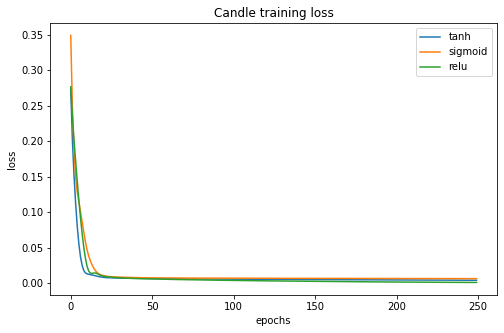

No handles with labels found to put in legend.

Plotting Best Testing Errors


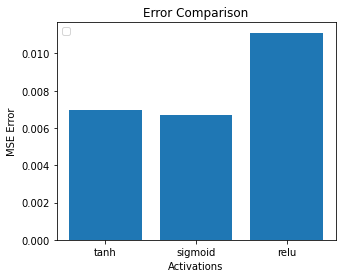


Plotting Best Testing r2
No handles with labels found to put in legend.


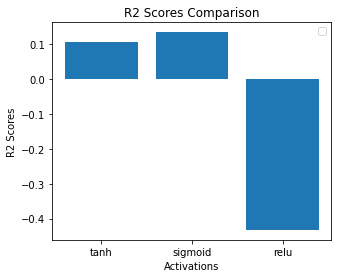


Plotting Predictions


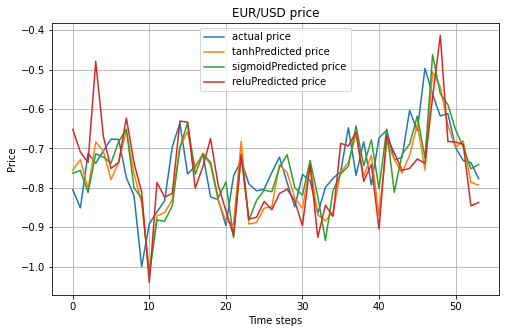

In [28]:
df = pd.read_csv('merged_data_tokenized_extra.csv',parse_dates=True,skipinitialspace=True,index_col='Date')

df_raw = df[raw_columns]
df_additional = df[forex_additional_column]
df_news = df[news_columns]
df_news_title = df[news_columns_title]
df_correlated_10 = df[correlated_10]
df_correlated_20 = df[correlated_20]
df_names =["Raw","Additional","News Title", "News","Correlated 10%","Correlated 20%", "All"]
dfs= [df_raw,df_additional,df_news_title,df_news,df_correlated_10,df_correlated_20,df]

all_losses = []
all_r2_scores = []
for name,current_df in zip(df_names,dfs):
    
    print("Testing df with",name,"Columns")

    print("\nSplitting and Creating Dataset")
    xtrain,ytrain,xtest,ytest = make_dataset(current_df)
    m = Models_FLF(activations)
    print("\nCreating and Training Models")
    m.train_all(xtrain, ytrain, units = 200, epochs = 250, verbose=0)
    print('\nEvaluating Models')
    losses,r2_scores  = m.evaluate(xtest)
    all_losses.append(losses)
    all_r2_scores.append(r2_scores)
    print("\nPlotting Testing Loss Over epochs")
    m.plot_validation_loss()
    print("\nPlotting Training Loss over Epochs")
    m.plot_train_loss()
    print("\nPlotting Best Testing Errors")
    m.plot_error(losses)
    print("\nPlotting Best Testing r2")
    m.plot_r2(r2_scores)
    print("\nPlotting Predictions")
    m.plot()
    print("\n")
    

In [29]:
# Single LSTM tokenized Only with Extra Words
x = PrettyTable()
x.field_names = ["Columns", "Activation", "Loss", "R2"]
for name,current_loss,current_r2 in zip(df_names,all_losses,all_r2_scores):
    for act in activations:
        x.add_row([name, act, current_loss[act][0], current_r2[act][0]])
print(x)

+----------------+------------+----------------------+----------------------+
|    Columns     | Activation |         Loss         |          R2          |
+----------------+------------+----------------------+----------------------+
|      Raw       |    tanh    | 0.005525497951067205 | 0.28786212629735564  |
|      Raw       |  sigmoid   | 0.005650723340952829 |  0.271722812940175   |
|      Raw       |    relu    | 0.006714093248975306 | 0.13467344798434455  |
|   Additional   |    tanh    | 0.006282842246682145 | 0.19025399014088806  |
|   Additional   |  sigmoid   | 0.006376648444796705 | 0.17816404873523983  |
|   Additional   |    relu    | 0.009797410041093668 | -0.2627109477273104  |
|   News Title   |    tanh    | 0.005412386567270424 | 0.30244016090381964  |
|   News Title   |  sigmoid   | 0.006554129098459591 | 0.15528996635531045  |
|   News Title   |    relu    | 0.006501499900787366 | 0.16207292877007984  |
|      News      |    tanh    | 0.005967829784779022 | 0.2308534